# EU members capitals comparison

## Introduction

This project aims to group similar capitals of EU countries into clusters and to compare similar neighbourhoods on those clusters to help people who want to live abroad or just meet places similar of those they love.

To achieve our objective the model will consider the type of venues existing on each neighbourhood of each place, which will be purchased using Foursquare API, and the cost of living on those cities, based on NUMBEO Cost of Living Index.

## Data importing and Pre-procesing

In [1]:
import pandas as pd
import folium # plot maps
from geopy.geocoders import Nominatim # get coordinates
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import numpy as np

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

### Cities Subdivisions Data

I got those values manualy and stored in a CSV. Let's first import the table.

__Import cities subdivisions table__

In [2]:
csd_file = 'EU_capitals_subdivisions.csv'
df = pd.read_csv(csd_file, encoding='utf-8')

Let's see how it looks like

In [3]:
df.head()

,Country,City,Subdivision
0,Austria,Vienna,Alsergrund
1,Austria,Vienna,Brigittenau
2,Austria,Vienna,Döbling
3,Austria,Vienna,Donaustadt
4,Austria,Vienna,Favoriten


In [4]:
df.describe(include='all')

,Country,City,Subdivision
count,474,474,474
unique,28,28,474
top,United Kingdom,London,Dublin 21
freq,33,33,1


__Geting the codinates of each subdivision__

Create a function to get the coordinates. Sometimes Geopy doesn't work properly, so I insert a loop to try 5 times each row, in case of error on that function.

In [5]:
geolocator = Nominatim(user_agent="eu_capitals")

def get_coordinates(subdivision, city, country):
    if(subdivision == None):
        place = city + ', ' + country
    else:
        place = subdivision + ', ' + city + ', ' + country
    lat = None
    lng = None
    t = 0
    while (lat is None) and (lng is None) and (t < 3): # In case of error, it tries up to 5 times retrieving the coordinates
        try:
            location = geolocator.geocode(place)
            lat = location.latitude
            lng = location.longitude
            break
        except:
            lat = None
            lng = None
            t = t + 1
    coordinates = str(lat) + ',' + str(lng)
    return coordinates

Apply the function to the dataframe

In [6]:
df['coordinates'] = df.apply(lambda x : get_coordinates(x.Subdivision, x.City, x.Country), axis=1)

Split the coordinates column into two

In [7]:
df['lat'] = df['coordinates'].str.split(",", n = 1, expand = True)[0]
df['lng'] = df['coordinates'].str.split(",", n = 1, expand = True)[1]
df.drop(columns =['coordinates'], inplace = True) 

Check for empty values

In [8]:
df[df.lat == 'None']

,Country,City,Subdivision,lat,lng
264,Latvia,Riga,Central District,None,None
265,Latvia,Riga,Kurzeme District,None,None
266,Latvia,Riga,Latgale Suburb,None,None
267,Latvia,Riga,Northern District,None,None
268,Latvia,Riga,Vidzeme Suburb,None,None
269,Latvia,Riga,Zemgale Suburb,None,None


The only city that never worked to get the coordinates was Riga, on Latvia. I tried to change the names of the districts to it's original language and to English but I didn't succeed with it, so I decided to export the coordinates I got until here and manually map the boroughs of this city and save into another CSV.

In [9]:
# Export
df.to_csv('coordinates.csv', index=False, encoding='utf-8')

In [10]:
# Import
url_coord = 'new_coordinates.csv'
df = pd.read_csv(url_coord, encoding='utf-8')

__Create a map to visualize locations__

In [11]:
latitude = 44.8584319
longitude = 3.1515146

# create map of New York using latitude and longitude values
map_eu = folium.Map(location=[latitude, longitude], zoom_start=4)

# add markers to map
for lat, lng, subdivision, city, country in zip(df['lat'], df['lng'], df['Subdivision'], df['City'], df['Country']):
    label = '{}, {}'.format(subdivision, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_eu)  
    
map_eu

### Cost of Living index

We'll use the Cost of Living Index from NUMBEO as a variable for compare cities (not neighbourhoods). Below a little explanation about this index, provided by NUMBEO on [this link](https://www.numbeo.com/cost-of-living/cpi_explained.jsp):
> These indices are relative to New York City (NYC). Which means that for New York City, each index should be 100(%). If another city has, for example, rent index of 120, it means that on an average in that city rents are 20% more expensive than in New York City. If a city has rent index of 70, that means on an average in that city rents are 30% less expensive than in New York City.

In [12]:
url_cost_living = 'https://www.numbeo.com/cost-of-living/rankings_current.jsp'
cost_living = pd.read_html(url_cost_living)
cost_living

[    0                                                  1
 0 NaN  What are you looking for? Cost of Living Crime...,     0      1
 0 NaN  Tweet,      Rank                              City  Cost of Living Index  Rent Index  \
 0     NaN               Zurich, Switzerland                126.71       61.39   
 1     NaN                Basel, Switzerland                125.38       45.77   
 2     NaN             Lausanne, Switzerland                123.50       51.10   
 3     NaN               Geneva, Switzerland                118.40       68.30   
 4     NaN                 Bern, Switzerland                115.20       40.53   
 5     NaN                 Stavanger, Norway                101.37       35.84   
 6     NaN       New York, NY, United States                100.00      100.00   
 7     NaN                Reykjavik, Iceland                 98.98       50.12   
 8     NaN                      Oslo, Norway                 98.95       42.94   
 9     NaN                    Bergen

In [13]:
# Let's filter just the data we need
cost_living = cost_living[2].iloc[:,1:]

In [14]:
# Rename the column City
cost_living = cost_living.rename(columns={'City' : 'CityCountry'})

In [15]:
# Let's see everything is ok
cost_living.head()

,CityCountry,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index
0,"Zurich, Switzerland",126.71,61.39,95.48,125.78,122.27,127.45
1,"Basel, Switzerland",125.38,45.77,87.33,124.80,121.22,121.56
2,"Lausanne, Switzerland",123.50,51.10,88.90,127.04,119.49,109.09
3,"Geneva, Switzerland",118.40,68.30,94.46,112.24,117.46,110.80
4,"Bern, Switzerland",115.20,40.53,79.51,107.26,110.86,132.57


In [16]:
df['CityCountry'] = df['City'] + ', ' + df['Country']

Merging both tables

In [17]:
d = df.merge(cost_living[['CityCountry', 'Cost of Living Index']], on='CityCountry', how='left')

In [18]:
d.head()

,Country,City,Subdivision,lat,lng,CityCountry,Cost of Living Index
0,Austria,Vienna,Alsergrund,48.225073,16.358398,"Vienna, Austria",64.68
1,Austria,Vienna,Brigittenau,48.243822,16.378147,"Vienna, Austria",64.68
2,Austria,Vienna,Döbling,48.261251,16.328471,"Vienna, Austria",64.68
3,Austria,Vienna,Donaustadt,48.214361,16.486072,"Vienna, Austria",64.68
4,Austria,Vienna,Favoriten,48.152994,16.382822,"Vienna, Austria",64.68


Let's see if everything is fine with this merging

In [19]:
d['Cost of Living Index'].unique()

array([64.68, 71.3 , 39.37, 49.46, 61.88, 48.49, 85.25, 51.83, 71.2 ,
       84.02, 63.88, 56.52, 42.59, 78.17, 69.27, 48.84, 43.73, 82.73,
         nan, 78.27, 43.21, 51.19, 38.64, 47.61, 54.  , 57.45, 75.1 ,
       80.93])

Some cities wasn't find. Let's check which ones:

In [20]:
d[d['Cost of Living Index'].isnull()][['CityCountry', 'Cost of Living Index']].drop_duplicates()

,CityCountry,Cost of Living Index
315,"Valletta, Malta",NaN


For some reason Valletta is not on the rank, but on it's index is 71.04, as shown on the following printscreen:

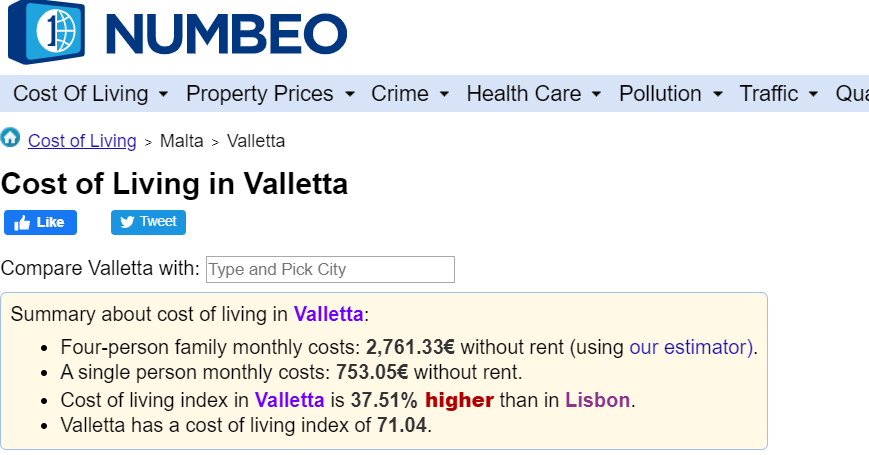

So I'll adjust it manually:

In [21]:
d.loc[d['CityCountry'] == 'Valletta, Malta', 'Cost of Living Index'] = 71.04

In [22]:
d[d['Cost of Living Index'].isnull()][['CityCountry', 'Cost of Living Index']].drop_duplicates()

,CityCountry,Cost of Living Index


Now we are good to go!

### Foursquare Venues

Define credentials (I have hidden it to upload to github)

In [23]:
CLIENT_ID = 'URRPDY0ZVALJZ0SUW414UADFFPOVAUUSUUBAGMA4DD5L1QVL' # your Foursquare ID
CLIENT_SECRET = 'B5M2OY1RNVD4J2XQW4C0PN1M05MMWIPKLSXGJGAZCCBQ32WT' # your Foursquare Secret
VERSION = '20200123' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: URRPDY0ZVALJZ0SUW414UADFFPOVAUUSUUBAGMA4DD5L1QVL
CLIENT_SECRET:B5M2OY1RNVD4J2XQW4C0PN1M05MMWIPKLSXGJGAZCCBQ32WT


Define limit and Radius

In [24]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
RADIUS = 500 # define radius

Define function that extracts the category of the venue

In [25]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Define function to extrat near places of each neighborhood

In [26]:
def getNearbyVenues(cities, subdivisions, latitudes, longitudes, radius=RADIUS):
    
    venues_list=[]
    for city, subdivision, lat, lng in zip(cities, subdivisions, latitudes, longitudes):
        print(city, ' : ', subdivision, ':', lat, ':', lng)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the GET request
        results = None
        t = 0
        while (results == None) & (t < 3): # some results aren't working, so I've put this loop to try again, in case of error
            try:
                results = requests.get(url).json()["response"]['groups'][0]['items']
                break
            except:
                results = None
                t = t + 1
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            city,
            subdivision,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City',
                             'Subdivision',
                             'Subdivision Latitude', 
                             'Subdivision Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues)

Get venues from each neighborhood

In [27]:
d.head()

,Country,City,Subdivision,lat,lng,CityCountry,Cost of Living Index
0,Austria,Vienna,Alsergrund,48.225073,16.358398,"Vienna, Austria",64.68
1,Austria,Vienna,Brigittenau,48.243822,16.378147,"Vienna, Austria",64.68
2,Austria,Vienna,Döbling,48.261251,16.328471,"Vienna, Austria",64.68
3,Austria,Vienna,Donaustadt,48.214361,16.486072,"Vienna, Austria",64.68
4,Austria,Vienna,Favoriten,48.152994,16.382822,"Vienna, Austria",64.68


I was having problems with Forsqare of 'quota exceeding' when reload the code, so I decided to save a CSV when the code worked and load this CSV when there is a problem with exceeding daily quota.

In [28]:
try:
    eu_venues = getNearbyVenues(cities= d['City'],
                                subdivisions = d['Subdivision'],
                                latitudes=d['lat'],
                                longitudes=d['lng'])
except:
    eu_venues = pd.read_csv('eu_venues.csv', encoding='utf-8')
else:
    eu_venues.to_csv('eu_venues.csv',encoding='utf-8', index=False)

Vienna  :  Alsergrund : 48.22507335 : 16.3583976


In [29]:
print(eu_venues.shape)
eu_venues.head()

(13853, 9)


,Unnamed: 0,City,Subdivision,Subdivision Latitude,Subdivision Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Vienna,Alsergrund,48.225073,16.358398,Beaver Brewing Company,48.224480,16.357040,Brewery
1,1,Vienna,Alsergrund,48.225073,16.358398,Veganista,48.224991,16.355842,Ice Cream Shop
2,2,Vienna,Alsergrund,48.225073,16.358398,blueorange - coffee & bagel,48.225307,16.355128,Café
3,3,Vienna,Alsergrund,48.225073,16.358398,Mast Weinbistro,48.225050,16.361550,Wine Bar
4,4,Vienna,Alsergrund,48.225073,16.358398,Kieser Training,48.226420,16.360920,Gym


In [30]:
eu_venues.groupby('City').count().sort_values('Subdivision Latitude')

,Unnamed: 0,Subdivision,Subdivision Latitude,Subdivision Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,,,
Nicosia,30,30,30,30,30,30,30,30
Bucharest,44,44,44,44,44,44,44,44
Valletta,60,60,60,60,60,60,60,60
Tallinn,67,67,67,67,67,67,67,67
Riga,68,68,68,68,68,68,68,68
Bratislava,101,101,101,101,101,101,101,101
Zagreb,172,172,172,172,172,172,172,172
Amsterdam,202,202,202,202,202,202,202,202
Warsaw,229,229,229,229,229,229,229,229


Insert cost of living on DataFrame

In [31]:
d.head()

,Country,City,Subdivision,lat,lng,CityCountry,Cost of Living Index
0,Austria,Vienna,Alsergrund,48.225073,16.358398,"Vienna, Austria",64.68
1,Austria,Vienna,Brigittenau,48.243822,16.378147,"Vienna, Austria",64.68
2,Austria,Vienna,Döbling,48.261251,16.328471,"Vienna, Austria",64.68
3,Austria,Vienna,Donaustadt,48.214361,16.486072,"Vienna, Austria",64.68
4,Austria,Vienna,Favoriten,48.152994,16.382822,"Vienna, Austria",64.68


In [32]:
eu_venues = eu_venues.merge(d[['City', 'Subdivision', 'Cost of Living Index']], on=['City', 'Subdivision'], how='left')

In [33]:
eu_venues = eu_venues.rename(columns={'Cost of Living Index' : 'cost_living'})

In [34]:
eu_venues.head()

,Unnamed: 0,City,Subdivision,Subdivision Latitude,Subdivision Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,cost_living
0,0,Vienna,Alsergrund,48.225073,16.358398,Beaver Brewing Company,48.224480,16.357040,Brewery,64.68
1,1,Vienna,Alsergrund,48.225073,16.358398,Veganista,48.224991,16.355842,Ice Cream Shop,64.68
2,2,Vienna,Alsergrund,48.225073,16.358398,blueorange - coffee & bagel,48.225307,16.355128,Café,64.68
3,3,Vienna,Alsergrund,48.225073,16.358398,Mast Weinbistro,48.225050,16.361550,Wine Bar,64.68
4,4,Vienna,Alsergrund,48.225073,16.358398,Kieser Training,48.226420,16.360920,Gym,64.68


Let's normalize the column cost_living

In [35]:
eu_venues['cost_living'].max()

85.25

In [36]:
eu_venues['cost_living'].min()

38.64

In [37]:
eu_venues['cost_living'] = (eu_venues['cost_living'] - eu_venues['cost_living'].min()) / (eu_venues['cost_living'].max() - eu_venues['cost_living'].min())

In [38]:
eu_venues.head()

,Unnamed: 0,City,Subdivision,Subdivision Latitude,Subdivision Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,cost_living
0,0,Vienna,Alsergrund,48.225073,16.358398,Beaver Brewing Company,48.224480,16.357040,Brewery,0.558678
1,1,Vienna,Alsergrund,48.225073,16.358398,Veganista,48.224991,16.355842,Ice Cream Shop,0.558678
2,2,Vienna,Alsergrund,48.225073,16.358398,blueorange - coffee & bagel,48.225307,16.355128,Café,0.558678
3,3,Vienna,Alsergrund,48.225073,16.358398,Mast Weinbistro,48.225050,16.361550,Wine Bar,0.558678
4,4,Vienna,Alsergrund,48.225073,16.358398,Kieser Training,48.226420,16.360920,Gym,0.558678


Check how many categories are in results

In [39]:
print('There are {} uniques categories.'.format(len(eu_venues['Venue Category'].unique())))

There are 480 uniques categories.


## Understanding Data

### Number of subdivisions on each EU capital

Text(0.5,1,'Number of subdivisions on each EU capital')

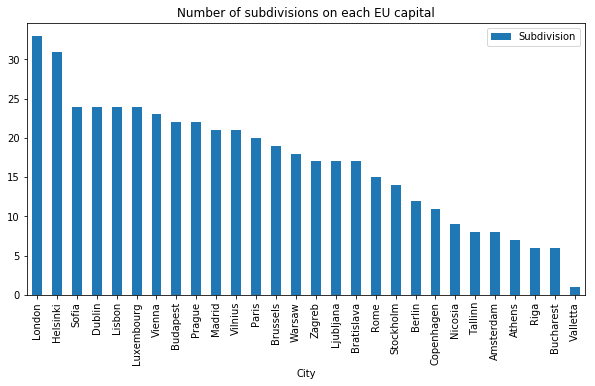

In [142]:
d.groupby('City')[['Subdivision']].count().sort_values('Subdivision', ascending=False).plot(kind='bar', figsize=(10,5))
plt.title('Number of subdivisions on each EU capital')

### Cost of Living Index in each city

Text(0.5,1,'Cost of Living Index')

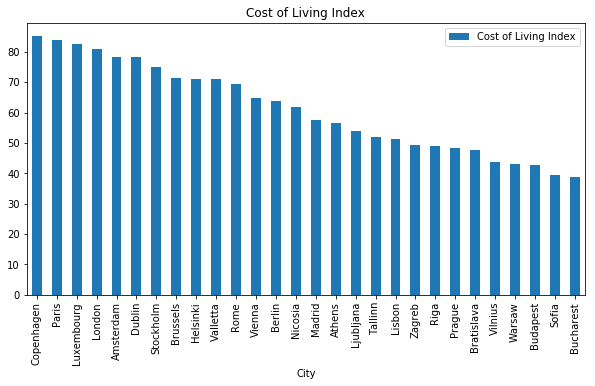

In [146]:
d.groupby('City')[['Cost of Living Index']].mean().sort_values('Cost of Living Index', ascending=False).plot(kind='bar', figsize=(10,5))
plt.title('Cost of Living Index')

In [235]:
print(d['Cost of Living Index'].max(), '\n',
      d['Cost of Living Index'].min(), '\n',
      d['Cost of Living Index'].max() / d['Cost of Living Index'].min())

85.25 
 38.64 
 2.206262939958592


In [240]:
eu_venues.shape

(13853, 10)

### Now let's see if larger cities has higher values of cost of living

Text(0.5,1,'Cost of living x Number of Subdivisions')

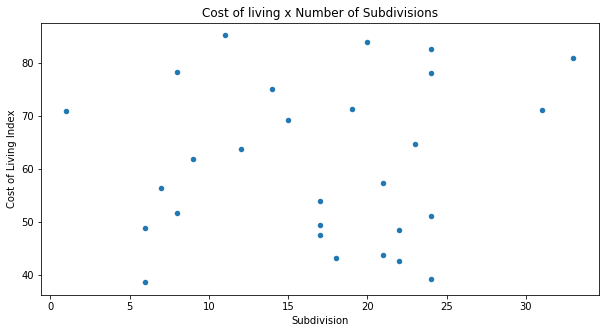

In [154]:
d.groupby('City').agg({'Subdivision' : 'count',
                      'Cost of Living Index' : 'mean'}).plot(kind='scatter',
                                                             x='Subdivision', y='Cost of Living Index', figsize=(10,5))
plt.title('Cost of living x Number of Subdivisions')

### Boxplot of number of venues per subdivision on each EU Capital

In [120]:
cont_city_venues = eu_venues.groupby(['City', 'Subdivision'], as_index=False)['Venue Category'].count()
#.plot(kind='box', x='City', y='Venue Category', figsize=(20,5))
box_data=[]
city_names=[]
for city in eu_venues.City.unique():
    box_data.append(list(cont_city_venues[cont_city_venues.City == city]['Venue Category']))
    city_names.append(city)

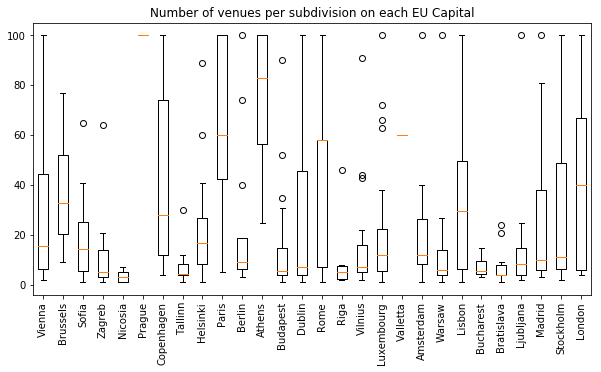

In [223]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Number of venues per subdivision on each EU Capital')
ax.boxplot(box_data)
#plt.xticks(city_names)
#ax.set_xticks(city_names)
ax.set_xticklabels(city_names, rotation=90)
plt.show()

### Concentation of Venue Categories

C:\Users\conta\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 'Venue Category' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


Text(0.5,1,'Top 30 venue categories on EU Capitals')

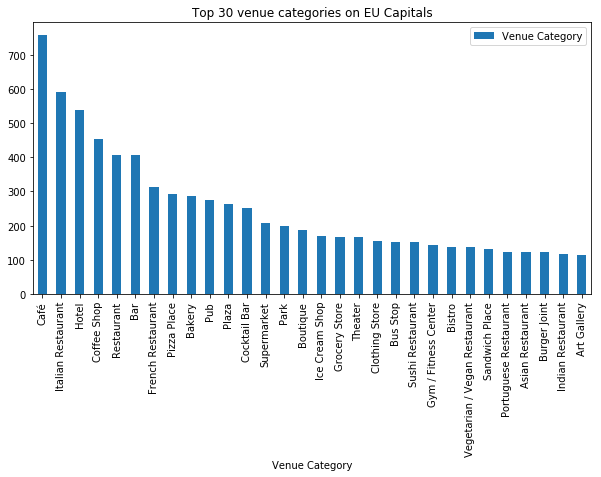

In [209]:
show_venues = 30
venues_grouped = eu_venues.groupby('Venue Category')[['Venue Category']].count().sort_values('Venue Category', ascending=False)
venues_grouped.iloc[:show_venues].plot(kind='bar', figsize=(10,5))
plt.xticks = concentration_venues['Venue Category']
plt.title('Top 30 venue categories on EU Capitals')

## Model

### Clustering the Cities

For the first phase of the project, we'll compare similar cities

#### Finding the proportions that each venue category has on each city

In [40]:
# One Hot Encoding
eu_cities_onehot = pd.get_dummies(eu_venues[['Venue Category', 'cost_living']], prefix="", prefix_sep="")

# Add city and cost of living columns back to datafame
eu_cities_onehot['City'] = eu_venues['City']

# move cities column to the first column
fixed_columns = [eu_cities_onehot.columns[-1]] + list(eu_cities_onehot.columns[:-1])
eu_cities_onehot = eu_cities_onehot[fixed_columns]

eu_cities_onehot.head()

,City,cost_living,ATM,Accessories Store,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,...,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Vienna,0.558678,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Vienna,0.558678,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Vienna,0.558678,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Vienna,0.558678,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,Vienna,0.558678,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Check dataframe size

In [41]:
eu_cities_onehot.shape

(13853, 482)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [42]:
eu_cities_grouped = eu_cities_onehot.groupby('City').mean().reset_index()
eu_cities_grouped

,City,cost_living,ATM,Accessories Store,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,...,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Amsterdam,0.850247,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.004950,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Athens,0.383609,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.001919,0.019194,0.005758,0.000000,0.000000,0.001919,0.000000,0.000000,0.000000
2,Berlin,0.541515,0.003571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.003571,0.003571,0.000000,0.000000,0.000000,0.010714,0.000000,0.000000
3,Bratislava,0.192448,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.009901,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Brussels,0.700708,0.000000,0.000000,0.000000,0.000000,0.005674,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.007092,0.002837,0.001418,0.000000,0.001418,0.001418,0.000000,0.000000
5,Bucharest,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Budapest,0.084746,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003003,0.000000,0.006006,0.003003,0.000000,0.000000,0.000000,0.018018,0.000000,0.000000
7,Copenhagen,1.000000,0.000000,0.000000,0.002268,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.013605,0.000000,0.000000,0.000000,0.002268,0.002268,0.000000,0.000000
8,Dublin,0.848101,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.006700,0.001675,0.000000,0.000000,0.003350,0.000000,0.000000,0.000000
9,Helsinki,0.698563,0.000000,0.000000,0.000000,0.000000,0.001541,0.000000,0.000000,0.000000,...,0.001541,0.000000,0.001541,0.001541,0.000000,0.000000,0.001541,0.006163,0.001541,0.000000


In [43]:
eu_cities_grouped.shape

(28, 482)

#### List of top 10 venues of each city

First, let's write a function to sort the venues in descending order.

In [44]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [45]:
eu_cities_grouped.head()

,City,cost_living,ATM,Accessories Store,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,...,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Amsterdam,0.850247,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.004950,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
1,Athens,0.383609,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.001919,0.019194,0.005758,0.000000,0.0,0.001919,0.000000,0.0,0.0
2,Berlin,0.541515,0.003571,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.003571,0.003571,0.000000,0.0,0.000000,0.010714,0.0,0.0
3,Bratislava,0.192448,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.009901,0.000000,0.0,0.000000,0.000000,0.0,0.0
4,Brussels,0.700708,0.000000,0.0,0.0,0.0,0.005674,0.0,0.0,0.0,...,0.0,0.000000,0.007092,0.002837,0.001418,0.0,0.001418,0.001418,0.0,0.0


In [46]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City', 'cost_living']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cities_venues_sorted = pd.DataFrame(columns=columns)
cities_venues_sorted['City'] = eu_cities_grouped['City']
cities_venues_sorted['cost_living'] = eu_cities_grouped['cost_living']

eu_cities_grouped2 = eu_cities_grouped.drop(columns='cost_living')

for ind in np.arange(eu_cities_grouped.shape[0]):
    cities_venues_sorted.iloc[ind, 2:] = return_most_common_venues(eu_cities_grouped2.iloc[ind, :], num_top_venues)


cities_venues_sorted.head()

,City,cost_living,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amsterdam,0.850247,Bar,Coffee Shop,Hotel,Café,Park,French Restaurant,Bakery,Soccer Field,Marijuana Dispensary,Bus Stop
1,Athens,0.383609,Café,Bar,Greek Restaurant,Hotel,Coffee Shop,Dessert Shop,Historic Site,Bakery,Theater,Wine Bar
2,Berlin,0.541515,Café,Bar,Italian Restaurant,Pizza Place,Supermarket,Pub,Bakery,Drugstore,Vegetarian / Vegan Restaurant,Hotel
3,Bratislava,0.192448,Restaurant,Pizza Place,Bus Stop,Pub,Beer Garden,Supermarket,Café,Bar,Playground,Bus Line
4,Brussels,0.700708,Italian Restaurant,Bar,Plaza,Sandwich Place,Bakery,Supermarket,Restaurant,French Restaurant,Pizza Place,Snack Place


#### Cluster cities

Run k-means to cluster the cities into 5 clusters.

In [47]:
# set number of clusters
kclusters = 5

cities_grouped_clustering = eu_cities_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cities_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 2, 1, 4, 3, 3, 0, 0, 4])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [48]:
# add clustering labels
cities_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

cities_merged = d

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
cities_merged = cities_merged.join(cities_venues_sorted.set_index('City'), on='City')

cities_merged.head() # check the last columns!

,Country,City,Subdivision,lat,lng,CityCountry,Cost of Living Index,Cluster Labels,cost_living,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Austria,Vienna,Alsergrund,48.225073,16.358398,"Vienna, Austria",64.68,2,0.558678,Café,Austrian Restaurant,Hotel,Italian Restaurant,Restaurant,Supermarket,Plaza,Bar,Ice Cream Shop,Clothing Store
1,Austria,Vienna,Brigittenau,48.243822,16.378147,"Vienna, Austria",64.68,2,0.558678,Café,Austrian Restaurant,Hotel,Italian Restaurant,Restaurant,Supermarket,Plaza,Bar,Ice Cream Shop,Clothing Store
2,Austria,Vienna,Döbling,48.261251,16.328471,"Vienna, Austria",64.68,2,0.558678,Café,Austrian Restaurant,Hotel,Italian Restaurant,Restaurant,Supermarket,Plaza,Bar,Ice Cream Shop,Clothing Store
3,Austria,Vienna,Donaustadt,48.214361,16.486072,"Vienna, Austria",64.68,2,0.558678,Café,Austrian Restaurant,Hotel,Italian Restaurant,Restaurant,Supermarket,Plaza,Bar,Ice Cream Shop,Clothing Store
4,Austria,Vienna,Favoriten,48.152994,16.382822,"Vienna, Austria",64.68,2,0.558678,Café,Austrian Restaurant,Hotel,Italian Restaurant,Restaurant,Supermarket,Plaza,Bar,Ice Cream Shop,Clothing Store


Let's check how many cities has in each cluster

In [49]:
city_clusters = cities_merged.groupby(['City', 'Country', 'Cluster Labels'], as_index=False).count()[['City', 'Country','Cluster Labels']]

Text(0.5,1,'City clusters using Cost of Living Index')

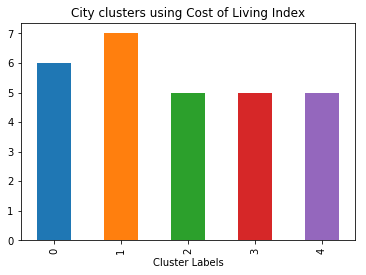

In [241]:
city_plot = city_clusters.groupby('Cluster Labels')['City'].count()
city_plot.plot(kind='bar')
plt.title('City clusters using Cost of Living Index')

Let's get the coordinates from each city

In [51]:
city_clusters['coordinates'] = city_clusters.apply(lambda x : get_coordinates(None, x.City, x.Country), axis=1)

... And split in the latitude and longitude

In [52]:
city_clusters['lat'] = city_clusters['coordinates'].str.split(",", n = 1, expand = True)[0]
city_clusters['lng'] = city_clusters['coordinates'].str.split(",", n = 1, expand = True)[1]
city_clusters.drop(columns =['coordinates'], inplace = True) 

Now let's see how our map is colouring the clusters

In [53]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_clusters['lat'], city_clusters['lng'], city_clusters['City'], city_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Clustering the subdivisions of cities

Now let's cluster cities subdivisions (boroughts, neighbourhoods) and see if something changes

#### Finding the proportions that each venue category has on each subdivision

In [54]:
# One Hot Encoding
eu_subdivision_onehot = pd.get_dummies(eu_venues[['Venue Category', 'cost_living']], prefix="", prefix_sep="")

# Add city column back to datafame
eu_subdivision_onehot['Subdivision'] = eu_venues['Subdivision']

# move cities column to the first column
fixed_columns = [eu_subdivision_onehot.columns[-1]] + list(eu_subdivision_onehot.columns[:-1])
eu_subdivision_onehot = eu_subdivision_onehot[fixed_columns]

eu_subdivision_onehot.head()

,Subdivision,cost_living,ATM,Accessories Store,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,...,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Alsergrund,0.558678,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Alsergrund,0.558678,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Alsergrund,0.558678,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Alsergrund,0.558678,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,Alsergrund,0.558678,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Check dataframe size

In [55]:
eu_subdivision_onehot.shape

(13853, 482)

Next, let's group rows by subdivision and by taking the mean of the frequency of occurrence of each category

In [56]:
eu_subdivision_grouped = eu_subdivision_onehot.groupby('Subdivision').mean().reset_index()
eu_subdivision_grouped

,Subdivision,cost_living,ATM,Accessories Store,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,...,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Aglantziá,0.498605,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
1,Ajuda,0.269256,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
2,Alcântara,0.269256,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
3,Alppiharju,0.698563,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
4,Alsergrund,0.558678,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.020408,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
5,Alvalade,0.269256,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
6,Amager East,1.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
7,Amager West,1.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
8,Anderlecht,0.700708,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
9,Antakalnis,0.109204,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0


In [57]:
eu_cities_grouped.shape

(28, 482)

#### List of top 10 venues of each city

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [58]:
eu_subdivision_grouped.head()

,Subdivision,cost_living,ATM,Accessories Store,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,...,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Aglantziá,0.498605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Ajuda,0.269256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Alcântara,0.269256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Alppiharju,0.698563,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alsergrund,0.558678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.020408,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
# create columns according to number of top venues
columns = ['Subdivision', 'cost_living']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
subdivision_venues_sorted = pd.DataFrame(columns=columns)
subdivision_venues_sorted['Subdivision'] = eu_subdivision_grouped['Subdivision']
subdivision_venues_sorted['cost_living'] = eu_subdivision_grouped['cost_living']

eu_subdivision_grouped2 = eu_subdivision_grouped.drop(columns='cost_living')

for ind in np.arange(eu_subdivision_grouped.shape[0]):
    subdivision_venues_sorted.iloc[ind, 2:] = return_most_common_venues(eu_subdivision_grouped2.iloc[ind, :], num_top_venues)

subdivision_venues_sorted.head()

,Subdivision,cost_living,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aglantziá,0.498605,Convenience Store,Bakery,Bar,Greek Restaurant,Zoo Exhibit,Farm,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant
1,Ajuda,0.269256,Gym,Surf Spot,Seafood Restaurant,Gas Station,Falafel Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service
2,Alcântara,0.269256,Soccer Stadium,Pool,Zoo Exhibit,Falafel Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant
3,Alppiharju,0.698563,Theme Park Ride / Attraction,Park,Greek Restaurant,History Museum,Theme Park,Theater,Bar,Gym,Dog Run,Café
4,Alsergrund,0.558678,Hotel,Café,Supermarket,Vietnamese Restaurant,Asian Restaurant,Austrian Restaurant,Tram Station,Japanese Restaurant,Restaurant,Indian Restaurant


#### Cluster subdivision

Run k-means to cluster the neighborhood into 5 clusters.

In [60]:
# set number of clusters
kclusters = 5

subdivision_grouped_clustering = eu_subdivision_grouped.drop('Subdivision', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(subdivision_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 4, 4, 2, 0, 0, 4, 1])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [61]:
# add clustering labels
subdivision_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

subdivision_merged = d

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
subdivision_merged = subdivision_merged.join(subdivision_venues_sorted.set_index('Subdivision'), on='Subdivision')

subdivision_merged.head() # check the last columns!

,Country,City,Subdivision,lat,lng,CityCountry,Cost of Living Index,Cluster Labels,cost_living,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Austria,Vienna,Alsergrund,48.225073,16.358398,"Vienna, Austria",64.68,4.0,0.558678,Hotel,Café,Supermarket,Vietnamese Restaurant,Asian Restaurant,Austrian Restaurant,Tram Station,Japanese Restaurant,Restaurant,Indian Restaurant
1,Austria,Vienna,Brigittenau,48.243822,16.378147,"Vienna, Austria",64.68,4.0,0.558678,Bus Stop,Supermarket,Plaza,Ice Cream Shop,Hostel,Tennis Court,Park,Grocery Store,Food Court,Restaurant
2,Austria,Vienna,Döbling,48.261251,16.328471,"Vienna, Austria",64.68,4.0,0.558678,Winery,Wine Bar,Bus Stop,Zoo Exhibit,Event Service,Factory,Fabric Shop,Exhibit,Event Space,Entertainment Service
3,Austria,Vienna,Donaustadt,48.214361,16.486072,"Vienna, Austria",64.68,4.0,0.558678,Indian Restaurant,Restaurant,Café,Soccer Field,Bus Stop,Dessert Shop,Bakery,Food & Drink Shop,Sushi Restaurant,Flea Market
4,Austria,Vienna,Favoriten,48.152994,16.382822,"Vienna, Austria",64.68,4.0,0.558678,Park,Shopping Mall,Food,Grocery Store,Athletics & Sports,Metro Station,Zoo Exhibit,Fabric Shop,Electronics Store,Empanada Restaurant


Let's check for empty values

In [62]:
empty_values = list(subdivision_merged[subdivision_merged['Cluster Labels'].isnull()]['Subdivision'])
print('There are' , len(empty_values) , 'empty subdivisions')
print('They are:' , empty_values)

There are 21 empty subdivisions
They are: ['Penzing', 'Ilinden', 'Iskar', 'Vazrazhdane', 'Vrabnitsa', 'Podsused – Vrapče', 'Trnje', 'Dublin 24', 'Grigiškės', 'Paneriai', 'Hamm', 'Białołęka', 'Devín', 'Jarovce', 'Podunajské Biskupice', 'Rusovce', 'Golovec', 'Fuencarral-El Pardo', 'Latina', 'Vicálvaro', 'Villa de Vallecas']


... and drop them (they are subdivisions that weren't found on Foursquare API)

In [63]:
subdivision_merged = subdivision_merged[~subdivision_merged['Cluster Labels'].isnull()]
print('There are' , len(list(subdivision_merged[subdivision_merged['Cluster Labels'].isnull()]['Subdivision'])) , 'empty subdivisions')

There are 0 empty subdivisions


In [64]:
subdivision_merged['Cluster Labels'] = subdivision_merged['Cluster Labels'].astype('int')

Let's check how many subdivisions has in each cluster

In [65]:
subdivision_clusters = subdivision_merged.groupby(['Subdivision', 'City', 'Country', 'Cluster Labels'], as_index=False).count()[['Subdivision', 'City', 'Country','Cluster Labels']]

Text(0.5,1,'Neighbourhood clusters')

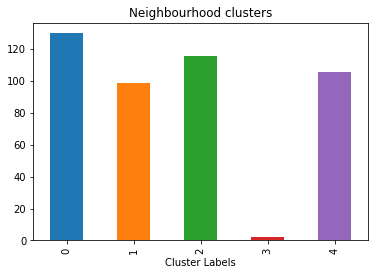

In [257]:
subdivision_plot = subdivision_clusters.groupby('Cluster Labels')['Subdivision'].count()
subdivision_plot.plot(kind='bar')
plt.title('Neighbourhood clusters')

In [67]:
subdivision_plot

Cluster Labels
0    130
1     99
2    116
3      2
4    106
Name: Subdivision, dtype: int64

Now let's see how our map is colouring the clusters

In [242]:
# create map
map_sub_clusters = folium.Map(location=[latitude, longitude], zoom_start=4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(subdivision_merged['lat'], subdivision_merged['lng'], subdivision_merged['Subdivision'], subdivision_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_sub_clusters)
       
map_sub_clusters

## Discussion and Conclusion

This project has showed that data can really help people who wants to choose a place to travel or to move based on their interests. but it appears that it works better recommending cities than neighbourhoods.

On neighbourhood clustering there were groups with more than 100 places to choose and when I tried to increase the value of K, new clusters had just one register, so it’s not a matter of the k number. Considering variables like population density, population aging, area, quality of public transportation and other social and demographic indices can enrich the model and, later, the results.

Another point of improvement of the model is how to get the venue information, because there are smaller and bigger neighbourhoods, so using a radius of 500 meters on borough of 8km² is to get less information than necessary. Beside this, some places had 10 or less venues and it can affect the model.

For future directions, I recommend improving the model in two ways:
1.	Adding new variables to the existing model and try to get more venues to the database using google maps API or other.
2.	Create a second model that gets information from user experiences and cluster the users.